In [1]:
# imports

import os
import os.path
import cv2
import glob
import h5py
import tqdm
import argparse
import logging
from PIL import Image 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_theme()
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

import sys
sys.path.append('../')
import data, utils, models

In [2]:
# EXAMPLE NUMBER
example = 0 # Set 1 for another example

In [3]:
# necessary variable deifnitons

parallel = True
Fast = False
pretrained = True
old = True
load_opt = False

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
transform = transforms.Compose([transforms.ToPILImage()])
to_gray = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1)])
center = transforms.Compose([transforms.CenterCrop(40)])

dataset = "CTC"
video = f"fluoro_{example+1}"
patch_size = 256
stride = 128
is_image = False
n_frames = 5
cpf = 1
mid = n_frames // 2
is_real = True

aug = 3

dist = 'G'
mode = 'S'
noise_std = 30
min_noise = 0
max_noise = 100

batch_size = 1
lr = 1e-4

In [4]:
# load model

PATH = "../pretrained/fluoro_micro.pt"

model, optimizer, args = utils.load_model(PATH, parallel=parallel, pretrained=pretrained, old=old, load_opt=load_opt)
model.to(device)
print(model)

BlindVideoNet(
  (rotate): rotate()
  (denoiser_1): Blind_UNet(
    (enc1): ENC_Conv(
      (conv1): Conv(
        (shift_down): ZeroPad2d(padding=(0, 0, 1, 0), value=0.0)
        (crop): crop()
        (replicate): ReplicationPad2d((1, 1, 1, 1))
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (conv2): Conv(
        (shift_down): ZeroPad2d(padding=(0, 0, 1, 0), value=0.0)
        (crop): crop()
        (replicate): ReplicationPad2d((1, 1, 1, 1))
        (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (conv3): Conv(
        (shift_down): ZeroPad2d(padding=(0, 0, 1, 0), value=0.0)
        (crop): crop()
        (replicate): ReplicationPad2d((1, 1, 1, 1))
        (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
  

In [5]:
# data loader

PATH = "../datasets/CTC"
train_loader, test_loader = data.build_dataset("CTC", PATH, batch_size=1, image_size=None)

In [6]:
# denoise

model.eval()

if example == 0:
    num = 18; x = 575; y = 475; w = 200; h = 200
elif example == 1:
    num = 100; x = 442; y = 886; w = 128; h = 128

with torch.no_grad():
    inputs = test_loader.dataset[num].unsqueeze(0)[:,:,y:y+h, x:x+w].to(device)
    outputs, _ = model(inputs)

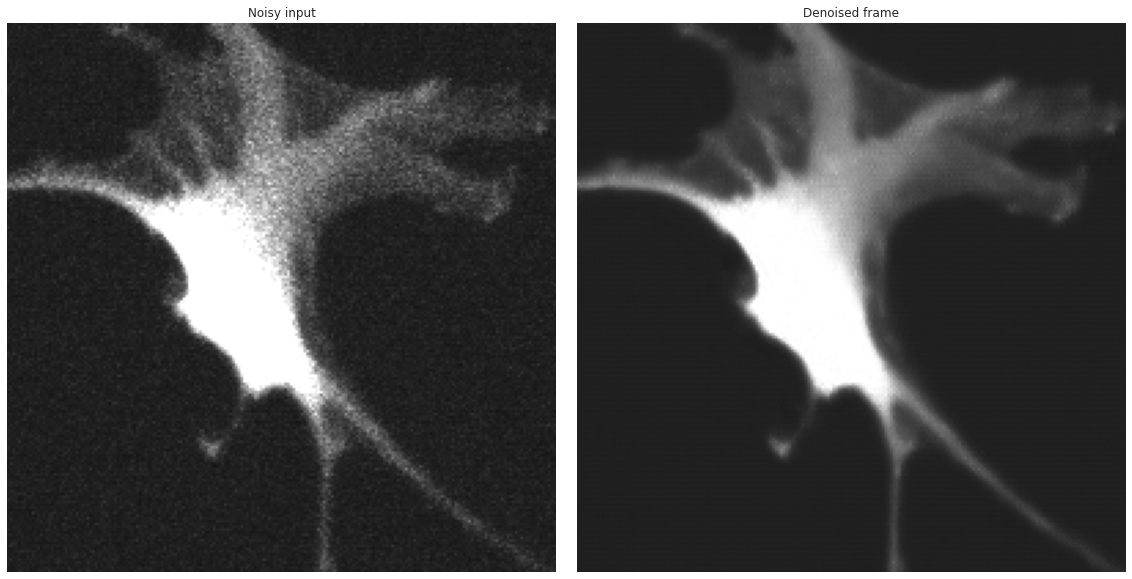

In [7]:
# plot

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

if is_image:
    ax1.imshow(inputs[0,0,:,:].cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1) 
else:
    ax1.imshow(inputs[0,2,:,:].cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1) 
ax1.set_title("Noisy input")
ax1.axis("off")

ax2.imshow(outputs[0,0,:,:].cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1) 
ax2.set_title("Denoised frame")
ax2.axis("off")

plt.tight_layout()

In [8]:
# denoise entire video

model.eval()

frames = []
os.makedirs(os.path.join("../examples", video), exist_ok=True)
save_dir = os.path.join("../examples", video)
C, H, W = test_loader.dataset[0].shape

if example == 0:
    x = 575; y = 475; w = 200; h = 200
elif example == 1:
    x = 450; y = 780; w = 200; h = 200

with torch.no_grad():
    for i, noisy_inputs in enumerate(test_loader):
        if example == 0:
            if i >= 48:
                break
        elif example == 1:
            if i < 96:
                continue
            if i >= 188:
                break
        noisy_inputs = noisy_inputs[:,:,y:y+h,x:x+w].to(device)
        
        N, C, H, W = noisy_inputs.shape
        noisy_frame = noisy_inputs[:, 2:3, :, :]
        
        output, _ = model(noisy_inputs)
        
        img = np.array((output[0]/max(1,output[0].max())).cpu().detach().numpy().reshape(w,h)*255, dtype=np.uint8)
        noisy_img = np.array((noisy_frame[0]/max(1,noisy_frame[0].max())).cpu().detach().numpy().reshape(w,h)*255, dtype=np.uint8)
        
        frame = cv2.cvtColor(np.append(noisy_img, img, axis=1), cv2.COLOR_GRAY2BGR)
        cv2.line(frame, (W,0), (W,H), (0,0,0), 1)
        
        cv2.imwrite(os.path.join(save_dir, "%05d.jpg" % (i)), frame)
        
        frames.append(frame)

In [9]:
# combining frames into mp4 video

fps = 24

video_path = os.path.join(save_dir, f"{video}.mp4")
height, width, layers = frames[0].shape
out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
for i in range(len(frames)):
    out.write(frames[i])
out.release()
cv2.destroyAllWindows()

In [10]:
# converting mp4 to a gif video (optional)

from moviepy.editor import *

video_path = os.path.join(save_dir, f"{video}.mp4")
gif_path = os.path.join(save_dir, f"{video}.gif")

clip = (VideoFileClip(video_path).resize(0.5))
clip.write_gif(gif_path)

t:  35%|███▌      | 17/48 [00:00<00:00, 156.42it/s, now=None]

MoviePy - Building file ../examples/fluoro_1/fluoro_1.gif with imageio.
